In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch, json
import random
import numpy as np
import tqdm
from utils_batch import InfillingModel
from torch.nn.functional import log_softmax
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



device = "cuda:1" # for GPU usage or "cpu" for CPU usage

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1050 Ti with Max-Q Design
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [28]:
def plot_roc_curve(human_scores, gpt_scores):
    # Data
    A, B = human_scores, gpt_scores
    # Combine scores and true labels
    scores = A + B
    labels = [0] * len(A) + [1] * len(B)
    # check amount of NaNs in scores
    if np.isnan(human_scores).any():
        print("Warning: NaNs in scores")
        print(np.argwhere(np.isnan(scores)))
    if np.isnan(gpt_scores).any():
        print("Warning: NaNs in scores")
        print(np.argwhere(np.isnan(scores)))
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Open-gen w/ GPT3.5-Reddit w prompts' )
    plt.legend(loc="lower right")
    plt.show()
    # what is the TPR for FPR = 0.1?
    for idx, fpr_ in enumerate(fpr):
        if fpr_ > 0.1:
            print(f"TPR at 1% FPR: {tpr[idx]:.4f}")
            break
    return roc_auc, tpr[idx]

In [4]:
model_name = "NinedayWang/PolyCoder-160M"
# NinedayWang/PolyCoder-0.4B
# NinedayWang/PolyCoder-2.7B
# model_name = 'codeparrot/codeparrot'
PyCodeGPT = AutoModelForCausalLM.from_pretrained( model_name ).to(device)
PyCodeGPT_tokenizer = AutoTokenizer.from_pretrained( model_name )

tokenizer_config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

D:\Artificial_Intelligence\Thesis\Code_detection\.venv\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sjoer\.cache\huggingface\hub\models--NinedayWang--PolyCoder-160M. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/981k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/437k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [ ]:
# from transformers import LlamaForCausalLM, LlamaTokenizer
# model_name = "/data/xianjun/project/llama/7B_hf/"
# model = LlamaForCausalLM.from_pretrained( model_name ).half().to(device) #.half() to use FP16
# model.eval() 
# PyCodeGPT = model
# PyCodeGPT_tokenizer = LlamaTokenizer.from_pretrained( model_name ) #.half() to use FP16

In [5]:
from transformers import AutoConfig
# Load the model's configuration
config = AutoConfig.from_pretrained(model_name)
# Get the default max_length
max_length = config.max_position_embeddings
max_length

2048

In [6]:
# give an input, return the logits of input tokens
inputs = 'this is a test'
truncate_ratio=0.9
def get_logprob1(inputs):
    input_ids = PyCodeGPT_tokenizer.encode(inputs, return_tensors='pt').to(device)
    input_ids = input_ids[:, :max_length]
    with torch.no_grad():
        output = PyCodeGPT(input_ids)
    logits = output[0]
    # Assuming the `logits` tensor contains the output from the model
    log_probs = log_softmax(logits, dim=-1)
    # Select the log probabilities for the specific tokens in the input
    input_log_probs = log_probs[0, torch.arange(log_probs.size(1)), input_ids[0]]
    # Multiply by -1 to get the negative log probabilities
    neg_log_probs = -input_log_probs
    neg_log_probs = neg_log_probs.cpu().numpy().tolist()
    return np.average( neg_log_probs[int( truncate_ratio*len(neg_log_probs)): ] ), neg_log_probs

In [7]:
#### merge the datasets
with open('results/regen_gpt-4-0314_20_0.7.jsonl', 'r') as f:
    data1  = [json.loads(line) for line in f]
len(data1)

164

In [8]:
data1[0]['machine_gen_text']['choices'][0]['message']['content']

'(numbers)):\n        for j in range(i+1, len(numbers)):\n            if abs(numbers[i] - numbers[j]) < threshold:\n                return True\n    return False'

In [9]:
human_text = data1[0]['machine_prefix_prompt'] + data1[0]['machine_gen_text']['choices'][0]['message']['content']
human_text

'from typing import List\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n    for i in range(len(numbers)):\n        for j in range(i+1, len(numbers)):\n            if abs(numbers[i] - numbers[j]) < threshold:\n                return True\n    return False'

In [10]:
len(data1[0]['machine_gen_text']['choices'])

20

In [11]:
avg_neg_log_probs, neg_log_probs = get_logprob1(human_text)
neg_log_probs[-500:]

[7.7765421867370605,
 20.779293060302734,
 7.912781715393066,
 17.257944107055664,
 1.417904257774353,
 2.2889280319213867,
 16.384384155273438,
 21.504213333129883,
 10.663066864013672,
 10.211968421936035,
 13.18709945678711,
 17.382457733154297,
 13.07573127746582,
 18.30043601989746,
 12.898963928222656,
 19.776874542236328,
 10.378148078918457,
 17.537128448486328,
 17.029447555541992,
 16.501020431518555,
 16.12957191467285,
 15.43078327178955,
 31.013277053833008,
 16.328227996826172,
 18.130165100097656,
 16.50117301940918,
 5.089354515075684,
 0.016253111883997917,
 0.0011507801245898008,
 7.75028133392334,
 11.270035743713379,
 13.489038467407227,
 7.812957763671875,
 8.67634105682373,
 7.419196128845215,
 8.779143333435059,
 9.284111022949219,
 8.83219051361084,
 11.110555648803711,
 6.7479705810546875,
 7.1661152839660645,
 9.955127716064453,
 9.762106895446777,
 9.976201057434082,
 8.310855865478516,
 11.977808952331543,
 10.110482215881348,
 7.264492034912109,
 4.02039432

In [12]:
# give an input, return the logits of input tokens
truncate_ratio=0.9
def get_logprob(inputs ):
    input_ids = PyCodeGPT_tokenizer.encode(inputs, return_tensors='pt').to(device)
    input_ids = input_ids[:, :max_length]
    with torch.no_grad():
        output = PyCodeGPT(input_ids)
    logits = output[0]
    # Assuming the `logits` tensor contains the output from the model
    log_probs = log_softmax(logits, dim=-1)
    # Select the log probabilities for the specific tokens in the input
    input_log_probs = log_probs[0, torch.arange(log_probs.size(1)), input_ids[0]]
    # Multiply by -1 to get the negative log probabilities
    neg_log_probs = -input_log_probs
    neg_log_probs = neg_log_probs.cpu().numpy().tolist()
    return np.average( neg_log_probs[int( truncate_ratio*len(neg_log_probs)): ] )

In [25]:
gold_prob_all = []
for id, ins in tqdm.tqdm(enumerate(data1), total=len(data1)):
    temp = []
    if len( ins['human_gen_text']['choices'] ) > 1:
        original_score = get_logprob( ins['gold_completion'] ) - get_logprob( ins['human_prefix_prompt'] )
        miu_scores = []
        for i in range( len(ins['human_gen_text']['choices'] ) ):
            one_regen = ins['human_prefix_prompt'] + ins['human_gen_text']['choices'][i]['message']['content']
            miu_scores.append( get_logprob( one_regen ) - get_logprob( ins['human_prefix_prompt'] ) )
        miu_scores_average_score = np.average( miu_scores )
        dx = original_score - miu_scores_average_score
        gold_prob_all.append( dx )

100%|██████████| 164/164 [04:19<00:00,  1.58s/it]


In [14]:
import tqdm
fim_prob_all = []
for id, ins in tqdm.tqdm(enumerate(data1), total=len(data1)):
    ins = data1[id]
    miu_scores = []
    original_score = get_logprob( ins['parsed_completion'] ) - get_logprob( ins['machine_prefix_prompt'])
    for i in range( len(ins['machine_gen_text']['choices'] ) ):
        one_regen = ins['machine_prefix_prompt'] + ins['machine_gen_text']['choices'][i]['message']['content']
        miu_scores.append( get_logprob( one_regen  ) - get_logprob( ins['machine_prefix_prompt'] ) )
    miu_scores_average_score = np.average( miu_scores )
    dx = original_score - miu_scores_average_score
    fim_prob_all.append( dx )

100%|██████████| 164/164 [05:42<00:00,  2.09s/it]


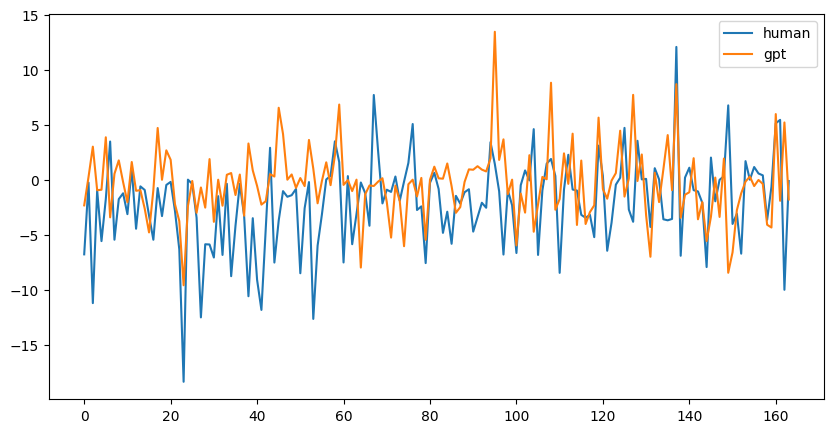

In [26]:
# plot and give different colors
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(gold_prob_all, label='human')
plt.plot(fim_prob_all, label='gpt')
plt.legend()
plt.show()

-5.57924938846069


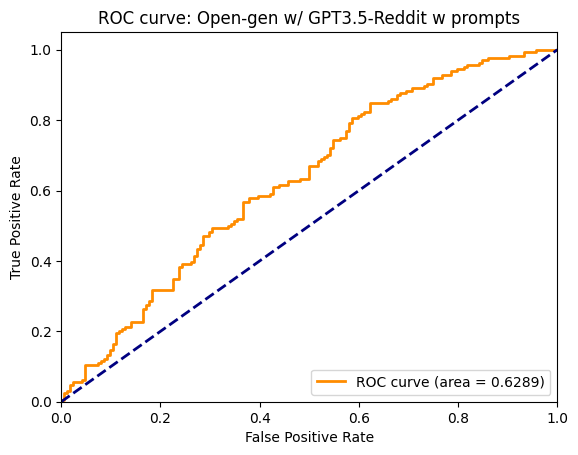

TPR at 1% FPR: 0.1463


(0.6289411064842356, 0.14634146341463414)

In [27]:


plot_roc_curve( gold_prob_all, fim_prob_all  )

In [31]:
# count negative values
print( len( [i for i in gold_prob_all if i < 0] ) )
print( len( [i for i in fim_prob_all if i < 0] ) )

119
93


In [30]:
print(gold_prob_all)

[-6.784833322431304, -0.2554696978180959, -11.220912861824036, -0.9563668945787611, -5.57924938846069, -1.7507354581947316, 3.477266070881752, -5.453238686919212, -1.7600060197125593, -1.2317058116867283, -3.1268231018198036, 1.056553094158411, -4.455368030924246, -0.6003510638350722, -0.9289405527772931, -3.2546012192964557, -5.455637767910957, -0.7561546335369353, -3.3036515438128795, -0.4724709107383145, -0.1938721832290753, -2.8242162096314125, -6.327624604105949, -18.374211579561234, 0.010798184091169283, -0.3817081284818986, -3.4478749604336922, -12.518420112133025, -5.866168802976608, -5.886759704351425, -7.073383577664693, -1.4923317578405366, -6.837204448790425, -0.3652838581550366, -8.769831721981367, -4.192781207672133, -0.3747397491726585, -3.2706472290332043, -10.594200892746448, -3.495421185845298, -9.103286669567119, -11.837503480911256, -4.534729480743408, 2.90851425097608, -7.530386649697802, -3.704647272825241, -1.0340085330382234, -1.5471260011189667, -1.404286246461